<img src="../../share/skience2020_logo.png"
     alt="Markdown Monster icon"
     width="300"
     style="float: right; margin-right: 100px;" />
     
# Hamiltonian Monte Carlo - Notebook 1
## Bayesian inference on Earthquake hypocenters accelerated with Hamiltonian Monte Carlo

##### Authors:
* Lars Gebraad ([@larsgeb](https://github.com/larsgeb))

##### Authors of the SeismoLive original:
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

* Kilian Geßele ([@KGessele](https://github.com/KGessele))

---

In this notebook, we'll be investigating the applicability of **Hamiltonian Monte Carlo** (HMC) to solving non-linear equations and Bayesian inference on their resulting inverse problems. We will look specificly at the Earthquake source-location problem, as presented also on the [SeismoLive website](https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Earthquake%20Location/el_hypocenter_wrapper.html). 

In the first section, we'll define the forward and the inverse problem, but this is not the focus of this notebook. These are merely needed to illustrate HMC. 

We'll look at the following sections:
1. Defining the inverse problem;
2. An conceptual comparison of Metropolis-Hastings and Hamiltonian Monte Carlo;
3. A more rigorous comparison of Metropolis-Hastings and Hamiltonian Monte Carlo;
4. A short interpretation of the physical results;
5. Influence of the mass matrix.

In [1]:
# This is a configuration step for the exercise

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# These are custom made imports
import samplers
from misc import marginal_grid

# Some style settings
plt.style.use('ggplot')
font = {'size'   : 18}
matplotlib.rc('font', **font)

If you prefer to work on a different inverse problem (e.g. other test functions), create a class that is structured as such:

In [2]:
class target_example:
    def misfit(self, m):
        return misfit

    def grad(self, m):
        return gradient

# Section 1: Setting up the inverse problem

In this short preparatory section, we will set up a basic hypocenter location inverse problem with unknown medium velocity. We will do this in three steps: 

1. First, we create a forward model predicting arrival times of earthquakes given a hypocenter location and bulk medium velocity. 
2. Then we create 'observed' data and together with observational uncertainties and prior information, compile everything into a target object, or posterior distribution. 
3. Lastly, because we want to perform HMC sampling, we also will define the gradient of the target distribution.

### Solution of the Forward Problem
For any arbitrary model, we can solve the forward problem using the following equation.

$$
\mathbf{d} = g(\mathbf{m})
$$

where the function $g$ describes the physical processes that associate the model $\mathbf{m}$ with the theoretical arrival times $\mathbf{d}$. In this exercise, we use a very simple geometrical concept and assume that the medium is homogeneous and the wave velocity $v$ is constant. Therefore, the theoretical arrival time $t_i$ at one particular station location {$x_i, z_i$} for an arbitrary source {$x, z, T$} in a medium with bulk velocity {$v$} is given by the following equation:


$$
t_i = g_i(x, z, T, v) = T + \frac{\sqrt{(x - x_i)^2 + (x - z_i)^2}}{v}
$$


In [3]:
# Defining the forward problem
def forward(m, station_x, station_z):
    """
    
    """

    
    
    # Dissassemble the model vector
    x = m[0]
    z = m[1]
    T = m[2]
    v = m[3]

    # Create an empty column vector for the data
    t_calc = np.empty((station_x.size, 1), dtype=np.float64)

    # Loop over the stations
    for istat in range(station_x.size):

        # Implement the formula for Earthquake first arrival times -------------

        t_calc[istat] = None # < here
        
        # ----------------------------------------------------------------------

        # Solution
        t_calc[istat] = (
            T
            + (1.0 / v)
            * ((x - station_x[istat]) ** 2.0 + (z - station_z[istat]) ** 2.0) ** 0.5
        )

    return t_calc

### Measure of fit

To perform an inversions (or inference), we need some criterion that assigns values to each model. This is typically done by comparing the simulated data (synthetics) to the observed data, and mapping these to a scalar function. This function, the misfit, is a measure of how 'good' a model is with respect to the observed data.

A typical choice would be the 'L2 misfit'. For the Earthquake source location this is is a quadratic function in residual traveltime (synthetic minus observed). It is given as:

$$
p(\mathbf{m}, \mathbf{t}_{obs}) = 
k\exp\Big(-\frac{1}{2} \sum_{i}\big(\frac{t_i(\mathbf{m}) - t_i^{obs}}{\sigma_i}\big)^2\Big)
$$  

$$
\chi(\mathbf{m}, \mathbf{t}_{obs}) = 
\frac{1}{2} \sum_{i}\left(\frac{t_i(\mathbf{m}) - t_i^{obs}}{\sigma_i}\right)^2
$$  

Here we define the Earthquake inversion measure of fit, or misfit


In [4]:
# Defining the misfit of the traveltimes
def misfit_tt(
    m,
    t_obs, # Observations
    uncertainties,
    station_x, 
    station_z, 
    depth_limit, # Prior
    v_mean, # Prior
    v_std, # Prior
):

    # Create synthetic data
    t_syn = forward(m, station_x, station_z)

    # Initialize misfit
    misfit = 0.0

    # == Likelihood ==
    
    # Loop over stations
    for istat in range(np.size(station_x)):
        misfit += ((t_syn[istat] - t_obs[istat]) ** 2) / (
            2.0 * uncertainties[istat] * uncertainties[istat]
        )

    # == Prior == 
    
    z = m[1]
    v = m[3]
    
    # Velocity prior
    misfit += ((v - v_mean) ** 2) / (2.0 * v_std * v_std)

    # Depth prior
    if z < 0.0 or z > depth_limit:
        misfit += np.inf

    return misfit

### Gradients of the data and misfit w.r.t. model parameters

$$
\chi(\mathbf{m}, \mathbf{t}_{obs}) = 
\frac{1}{2} \sum_{i}\left(\frac{t_i(\mathbf{m}) - t_i^{obs}}{\sigma_i}\right)^2
$$  

More explicitly, we have a scalar valued function that depends on the synthetic data, which in turn depends on the model parameters.

$$
\chi(\mathbf{m}) = f\left(\mathbf{d}(\mathbf{m})\right)
$$  

Applying the chain rule for the derivative:

$$
\partial_\mathbf{m} \chi(\mathbf{m}) = \left[\partial_\mathbf{d} f\left(\mathbf{d}(\mathbf{m})\right)\right] \cdot \partial_\mathbf{m}\mathbf{d}(\mathbf{m})
$$  

With nd datapoints and nm model parameters:

$$
\partial_\mathbf{d} f\left(\mathbf{d}(\mathbf{m})\right) = 1 \times nd\\
\partial_\mathbf{m}\mathbf{d}(\mathbf{m}) = nd \times nm
$$ 

making the total gradient:

$$
\partial_\mathbf{m} \chi(\mathbf{m}) = 1 \times nm
$$

In [5]:
# Define the gradient of the misfit (and prior) using the chain rule
def gradient_data(m, station_x, station_z):
    """
    Returns tensor containing the covariant derivative of the data w.r.t. the model
    parameters, i.e. the gradient of a vector function.
    
    Each column is a parameter, each row a station.
    """

    x = m[0]
    z = m[1]
    T = m[2]
    v = m[3]

    grad_t_calc = np.empty((station_x.size, 4), dtype=np.float64)

    for istat in range(np.size(station_x)):  # Loop over number of stations

        # dd / dx
        grad_t_calc[istat, 0] = (1.0 / v) * (
            (x - station_x[istat])
            / np.sqrt((x - station_x[istat]) ** 2.0 + (z - station_z[istat]) ** 2.0)
        )

        # dd / dz
        grad_t_calc[istat, 1] = (1.0 / v) * (
            (z - station_z[istat])
            / np.sqrt((x - station_x[istat]) ** 2.0 + (z - station_z[istat]) ** 2.0)
        )

        # dd / dT
        grad_t_calc[istat, 2] = 1

        # dd / dv
        grad_t_calc[istat, 3] = -(1.0 / (v * v)) * np.sqrt(
            (x - station_x[istat]) ** 2.0 + (z - station_z[istat]) ** 2.0
        )

    return grad_t_calc

def gradient_misfit_chain_rule(
    m,
    t_obs,
    uncertainties,
    station_x,
    station_z,
    v_mean,
    v_std,
    depth_limit,
):
    """
    Returns covector containing the gradient of the misfit w.r.t. the model
    parameters, i.e. the gradient of a scalar function. Implemented using
    component wise analytical formulas and the chain rule. 
    
    Each column is a parameter.
    """

    t_syn = forward(m, station_x, station_z)
    grad_t_syn = dd_dm(m, station_x, station_z)

    grad_misfit = np.empty((1, station_x.size))

    for istat in range(np.size(station_x)):

        grad_misfit[0, istat] = (
            2.0
            * (t_syn[istat] - t_obs[istat])
            / (2.0 * uncertainties[istat] * uncertainties[istat])
        )

    grad_misfit = grad_misfit @ grad_t_syn

    # Applying prior on velocity
    v = m[3]
    grad_misfit[0, 3] += 2.0 * (v - v_mean) / (2.0 * v_std * v_std)

    return grad_misfit

Alternatively, you can also consider the entire misfit function only a function of model parameters. That just means that the analytical derivatives will be a bit harder. Many times, this is actually beneficial for implementation speed, because implementations can optimize combined floating point operations. An example implementation is given below

In [6]:
# Define the gradient of the misfit (and prior) in one go; analytically
def gradient_misfit_analytical(
    m, t_obs, uncertainties, station_x, station_z, v_mean, v_std, depth_limit
):
    """
    Returns covector containing the gradient of the misfit w.r.t. the model
    parameters, i.e. the gradient of a scalar function. Implemented using
    analytical derivative.
    
    Each column is a parameter.
    """

    grad_misfit = np.zeros((1, 4))

    x = m[0]
    z = m[1]
    T = m[2]
    v = m[3]

    for istat in range(np.size(station_x)):

        xs = station_x[istat]
        zs = station_z[istat]
        t0 = t_obs[istat]

        d = ((x - xs) ** 2 + (z - zs) ** 2) ** 0.5

        A = 2 * uncertainties[istat] * uncertainties[istat]

        grad_misfit[0, 0] += 2 * (x - xs) * (T - t0 + d / v) / (v * d * A)
        grad_misfit[0, 1] += 2 * (z - zs) * (T - t0 + d / v) / (v * d * A)
        grad_misfit[0, 2] += 2 * (T - t0 + d / v) / A
        grad_misfit[0, 3] += -2 * d * (T - t0 + d / v) / (v * v * A)

    grad_misfit[0, 3] += 2 * (v - v_mean) / (2 * v_std * v_std)

    return grad_misfit

### Compiling everything into something neat (a class)

To make working with the data a little easier, we wrap all the settings associated with the inverse problem into a neat package; a class. This 'target' class only needs:
* A constructor to set up;
* A target.misfit(m) to evaluate a misfit;
* A target.grad(m) to evaluate a gradient.

We can just re-use the functions for misfits and gradients we defined in the cells before to create this class.

In [7]:
# Create the class (a sort of template) which contains all the inverse problem components
class target_tt:
    def __init__(self, t_obs, uncertainties, station_x, station_z, v_mean, v_std, depth_limit):
        
        # Sanity check
        if np.array([station_x, station_z, uncertainties]).size != station_x.size*3:
                print('ERROR: "station_x, station_z, uncertainties" must have same length')
                raise NotImplementedError
        
        # Assign defaults
        self.t_obs = t_obs
        self.uncertainties = uncertainties
        self.station_x = station_x
        self.station_z = station_z
        self.v_mean = v_mean
        self.v_std = v_std
        self.depth_limit = depth_limit

        # Some householding
        self.labels = [
            "Horizontal source location",
            "Vertical source location",
            "Origin time",
            "Medium velocity",
        ]
        self.units = ["km", "km", "s", "km/s"]

    # Optional, could also be programmed directly into misfit
    def forward(self, m):
        return forward(m, self.station_x, self.station_x)
        
    def misfit(self, m):
        return misfit_tt(
            m,
            t_obs = self.t_obs,
            uncertainties=self.uncertainties,
            station_x=self.station_x,
            station_z=self.station_z,
            v_mean=self.v_mean,
            v_std=self.v_std,
            depth_limit=self.depth_limit,
        )

    def grad(self, m):
        return gradient_misfit_analytical(
            m,
            t_obs = self.t_obs,
            uncertainties=self.uncertainties,
            station_x=self.station_x,
            station_z=self.station_z,
            v_mean=self.v_mean,
            v_std=self.v_std,
            depth_limit=self.depth_limit,
        ).T

## Creating some 'real' data

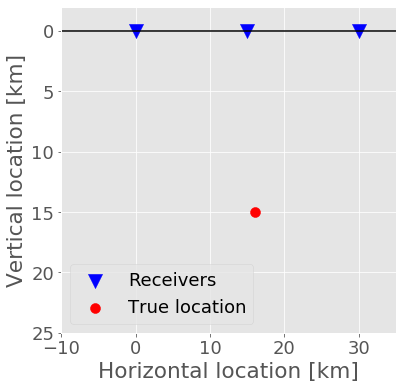

In [8]:
# Define the true event properties and receiver network, and plot these

# Define earthquake source properties
source_x = 16.0
source_z = 15.0
origin_T = 17.0
v_exact = 5.0

# Define station coordinates of the array
station_x = np.array([0, 15.0, 30.0])
station_z = np.array([0.0, 0.0, 0.0])

fig, axes = plt.subplots(figsize=(6, 6))
axes.scatter(station_x, station_z, color="b", marker="v", s=200, label="Receivers")
axes.scatter(source_x, source_z, color="r", marker=".", s=400, label="True location")
axes = plt.gca()
axes.set_xlabel("Horizontal location [km]")
axes.set_ylabel("Vertical location [km]")
axes.plot([-10, 35], [0, 0], "k")
axes.set_xlim([-10, 35])
axes.set_ylim([25, -2])
axes.legend();

In [9]:
# Create the 'true' (observed) data and obervational uncertainties

# Create a vector out of the true values
m_true = np.array([source_x, source_z, origin_T, v_exact])

# Calculate observed (exact) arrival times for all stations
t_obs = forward(m_true, station_x, station_z)

# Define uncertainties for the observed arrival time at each station. These are repeated for all events.
uncertainties = np.array([0.5, 0.3, 0.2])

assert t_obs.size == uncertainties.size

print("Observed data (arrival time in seconds w.r.t. the clock on the seismograph):\n", t_obs)
print("Data shape:\n", t_obs.shape)

Observed data (arrival time in seconds w.r.t. the clock on the seismograph):
 [[21.38634244]
 [20.00665928]
 [21.10365691]]
Data shape:
 (3, 1)


## Adding prior information

As you might have seen in the misfit definition, there are three parameters passed that refer to the prior. These are two parameters for a Gaussian prior on the velocity of the medium, as well as a hard limit for Earthquake source depth. In the actual function, you can see how these add to the misfit.

The prior on the Gaussian is a quadratic term which is added to the misfit function, defined by parameters `v_mean` and `v_std`:

$$
\chi(\mathbf{m}) = \chi_\text{data}(\mathbf{m}) + \frac{(v_\text{current_model} - v_\text{mean})^2}{2 v_\text{std}^2}
$$

Additionally, the depth of the Earthquake is limited to `depth_limit`, as well as being required to be below the surface of the 'Earth' (i.e. depth $> 0$). We can incorporate these strict boundaries by adding infinity to our misfit term when appropriate:

$$
\chi_\text{final}(\mathbf{m}) = \begin{cases}
\chi(\mathbf{m}) \quad 0 < \text{depth} < \text{depth_limit} \\
\infty \quad else\\
\end{cases}.
$$

In [10]:
# Define prior information on depth and velocity
v_mean = 4.5
v_std = 1
depth_limit = 25.0

## Creating the inverse problem 'object' from the class 

Now we roll everything up into a simple class:

In [11]:
# Collect the inverse problem into a object using the class 'template'
target = target_tt(t_obs, uncertainties, station_x, station_z, v_mean, v_std, depth_limit)

# Section 2: An animated comparison of MH and HMC

**Prior to this notebook, I pre-computed samples by running HMC and MH for longer than 10 minutes. We'll use these samples as a reference distribution.**

In [12]:
# Load a reference distribution. This is only for illustratory purposes.
# You could e.g. also use the samples from a previous sampling attempt
samples_MH_REF = np.load("ref_solutions/single_event_reference_MH_three_receivers.npy")
samples_HMC_REF = np.load("ref_solutions/single_event_reference_HMC_three_receivers.npy")

## Metropolis-Hastings sampling

The Metropolis-Hastings algorithm is a very fundamental, useful and robust algorithm. The most common variant constructs a Markov chain over our target distribution the following way:

1. Start at some initial model $m_\text{start}$
2. Draw a perturbation according to the proposal distribution $dm \propto P(dm|m_\text{start})$
3. Propose a new model as $m_\text{start} + dm = m_\text{new}$
4. Check if this new model is likely  (evaluate $P(m_\text{new})$ ):
    * If more likely, move there always.
    * If less likely, move there $\propto dP$
5. Repeat by drawing new perturbation

Investigating this thing visual is almost always a better idea. The file `samplers.py` provides a 'visual' MH sampler, which plots 2 dimensions of any distribution on the fly. Additionally, it allows us to plot a reference distribution in the background, e.g. a prior or a previous run.

In the next notebook cell I load reference samples which I precomputed (from about 10 minutes of sampling) of exactly the same target distribution.

**Try changing the step length `epsilon` and see what the algorithm does.** As a guideline, try to get the acceptance rate at 50%.

<IPython.core.display.Javascript object>


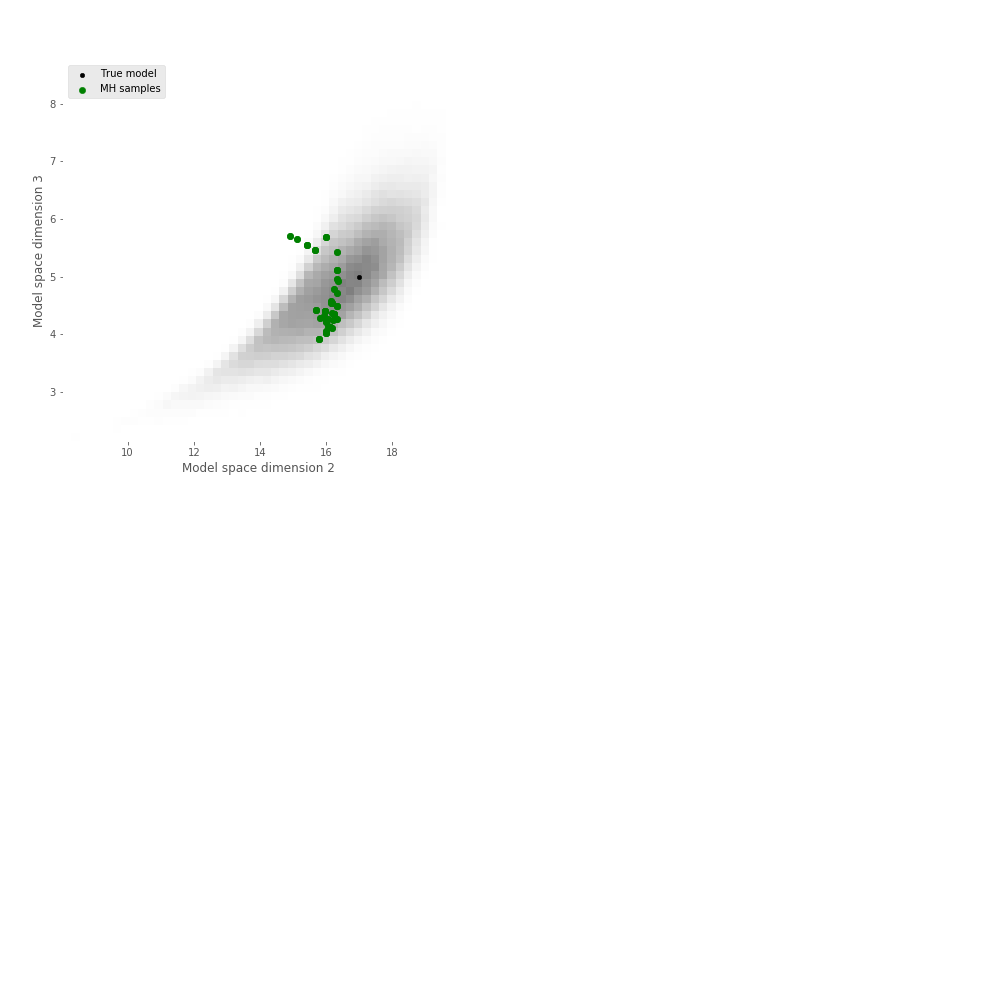

In [13]:
# Perform the same sampling using MH

m_start = np.array([16.1, 15.2, 14.9, 5.7])[:, None]

# Tuning parameters =============================================================================================
epsilon = 0.2
number_of_samples = 50
# End ===========================================================================================================

# Select which dimensions to animate (2D at most is easiest on computer screens)
dims_to_visualize = [2, 3]
figsize=(7,7)
animate_proposal=True # Disable this with 'False' if you find the animation annoying

%matplotlib notebook
samples_MH_1 = samplers.visual_sample_mh(
    target,
    m_start,
    epsilon,
    number_of_samples,
    figsize=figsize,
    dims_to_visualize=dims_to_visualize,
    background_samples=samples_MH_REF,
    true_m=m_true,
    animate_sample_interval=1,
    animate_proposal=animate_proposal, 
)
%matplotlib inline

What we can see in generating a few samples using MH is that the distance traversed in an accepted move and acceptance rate trade-off; if I try to move greater distances, less samples are accepted. With only 100 samples, we do not approximate the distribution well, regardless of step length.

Maybe there is an algorithm that an de better with such few samples ...

### Using 'physics': Hamiltonian Monte Carlo

We've seen in the presentation that HMC is harder to tune. We have a `mass matrix`, a step length (`dt`) and a number of steps (`nt`). 

**Try changing the tuning parameters to see what the effect is on the behaviour of the algorithm.** As a guideline, try to get the acceptance rate at 50%.

<IPython.core.display.Javascript object>


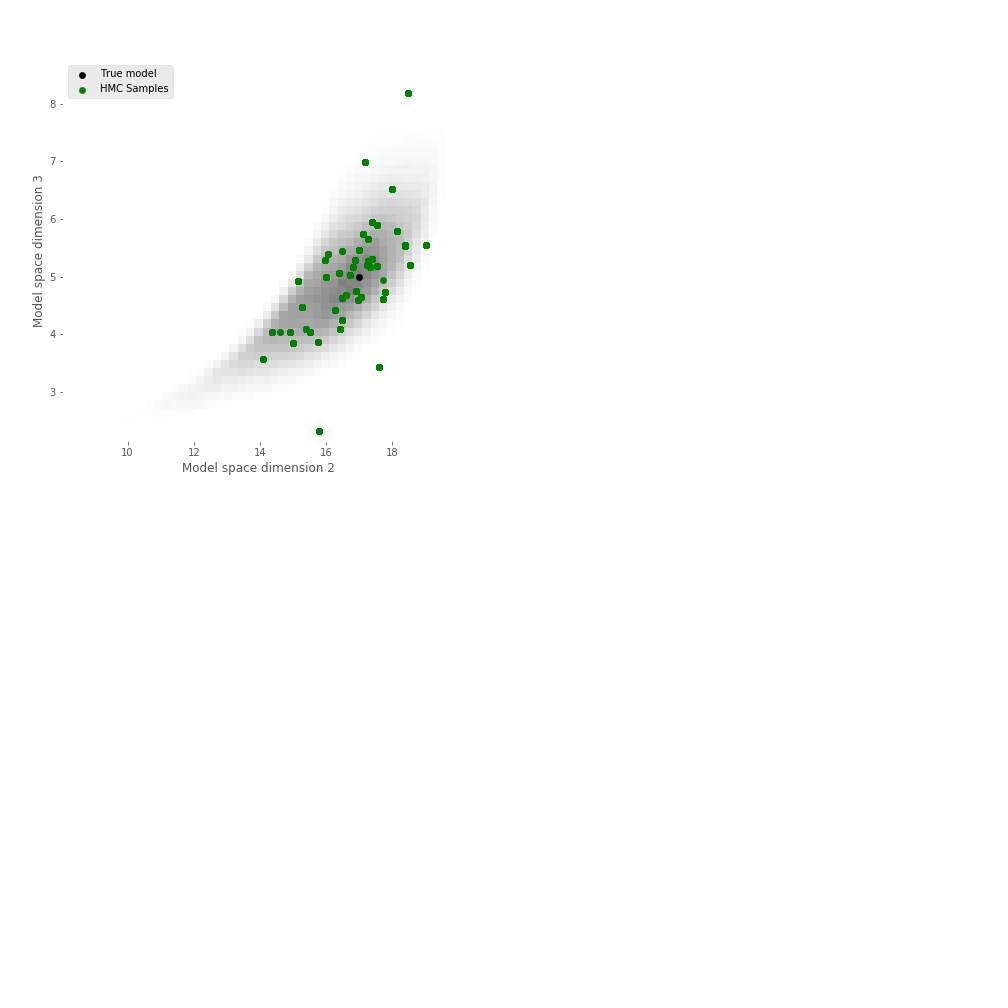

In [14]:
# Sampling using the basic HMC algorithm, but animated

# Select a starting model
m_start = np.array([16.1, 15.2, 14.9, 5.7])[:, None]

# Choose which dimensions to animate
dim_to_vis = [2, 3]
figsize=(7,7)
animate_trajectory=True # Disable this with 'False' if you find the animation annoying
animate_trajectory_interval=10 # Lower this number to slow down the animation

# Tuning parameters =============================================================================================
# These next two are equivalent
# mass_matrix = np.eye(4)
mass_matrix = np.array(
    [
        [1, 0, 0, 0],  
        [0, 1, 0, 0],  
        [0, 0, 1, 0],  
        [0, 0, 0, 1],
    ], dtype=np.float32
)  
dt = 0.05
nt = 100
number_of_samples = 50

# Sampling! =====================================================================================================
%matplotlib notebook
samples_HMC_1 = samplers.visual_sample_hmc(
    target,
    m_start,
    nt,
    dt,
    number_of_samples,
    mass_matrix,
    figsize=figsize,
    dims_to_visualize=dim_to_vis,
    background_samples=samples_MH_REF,
    true_m=m_true,
    animate_trajectory=animate_trajectory,
    animate_trajectory_interval=animate_trajectory_interval, # Lower this number to slow down the animation
)
%matplotlib inline

# Section 3: A qualitative comparison of MH and HMC

Now that we have an intuition of what the algorithms do, we can do a little more of a serious comparison. For this, we'll use un-animated algorithms, such that we get **maximum** speed. 

Additionally, we request 5000 proposals from each algorithm. That does not mean we get 5000 independent samples, just 5000 attempts to move to a new state. First we'll look at the perfomance (the time it takes to generated 5000 samples) and afterwards at the quality of these samples.

In [15]:
# Sampling using the basic MH algorithm
m_start = np.array([16.1, 15.2, 17.3, 4.7])[:, None]

# Tuning parameters
epsilon = 0.15
number_of_samples = 5000

# Sampling
%time samples_MH = samplers.sample_mh(target, m_start, epsilon, number_of_samples);


CPU times: user 846 ms, sys: 32.2 ms, total: 878 ms
Wall time: 992 ms


In [16]:
# Sampling using the basic HMC algorithm
m_start = np.array([16.1, 15.2, 17.3, 4.7])[:,np.newaxis]

# Tuning parameters
# mass_matrix = np.eye(4)
mass_matrix = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ], dtype=np.float32
)  
dt = 0.13
nt = 40
number_of_samples = 5000

# Sampling
%time samples_HMC = samplers.sample_hmc(target, m_start, nt, dt, number_of_samples, mass_matrix)


CPU times: user 3min 18s, sys: 11.1 s, total: 3min 29s
Wall time: 1min 5s


The difference in performance for these algorithms is extreme. MH can generate 5000 samples in **under 0.5 seconds** on my machine (a 2018 high end laptop), while HMC takes **about 20 seconds**. 

But, performance isn't the only thing. The ability of a Markov chain to generate **independent** samples is just as important. To get a feeling of the *quality* of samples, we now compare the resulting two distributions to the reference distribution computed by **many** samples from HMC and MH.

The next cell plots the marginals for both chains and compares them to the reference solutions. Additionally, **the true model values are plotted as the black vertical lines**.

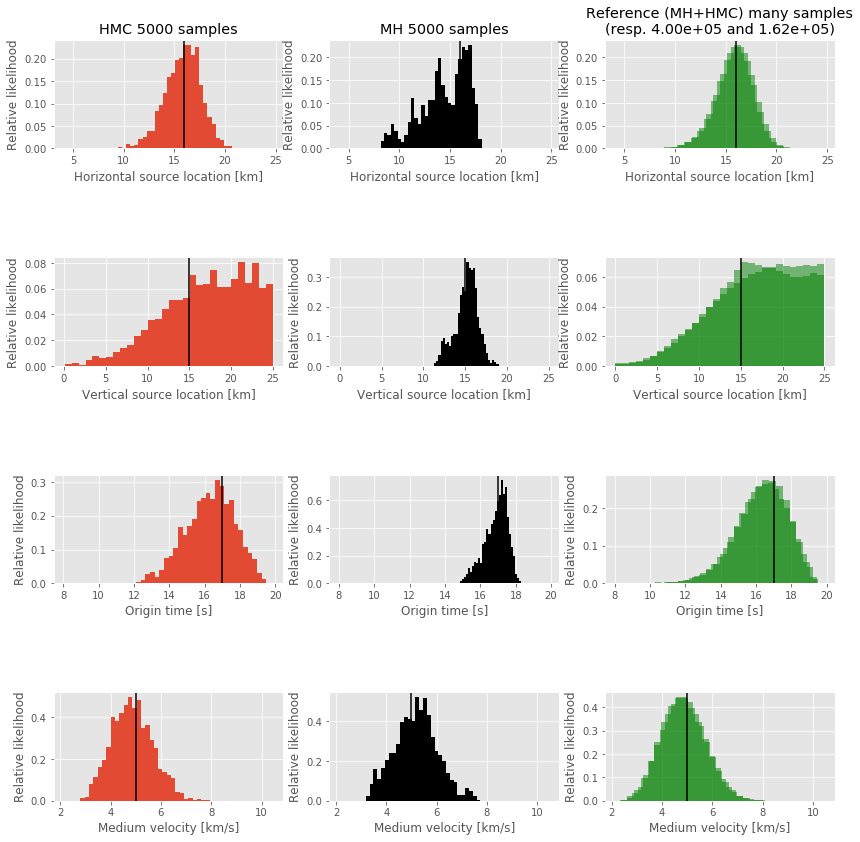

In [17]:
# Visualize 1D marginals for all algorithms
%matplotlib inline
bins = int(5000 ** 0.4)

limits = []

figure, axes = plt.subplots(4, 3, figsize=(14, 14), constrained_layout=False)
for i in range(4):
    axes[i, 0].hist(samples_HMC[i, :], bins=bins, density=True)
    ylim = axes[i, 0].get_ylim()
    axes[i, 0].plot([m_true[i], m_true[i]], [0, 1], "k")
    axes[i, 0].set_ylim(ylim)
    axes[i, 0].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))
    axes[i, 0].set_ylabel("Relative likelihood")

    axes[i, 1].hist(samples_MH[i, :], bins=bins, density=True, color="k")
    ylim = axes[i, 1].get_ylim()
    axes[i, 1].plot([m_true[i], m_true[i]], [0, 1], "k")
    axes[i, 1].set_ylim(ylim)
    axes[i, 1].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))
    axes[i, 1].set_ylabel("Relative likelihood")

    axes[i, 2].hist(
        samples_HMC_REF[i, :], bins=bins, density=True, alpha=0.5, color="g"
    )
    axes[i, 2].hist(samples_MH_REF[i, :], bins=bins, density=True, alpha=0.5, color="g")
    ylim = axes[i, 2].get_ylim()
    axes[i, 2].plot([m_true[i], m_true[i]], [0, 1], "k")
    axes[i, 2].set_ylim(ylim)
    axes[i, 2].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))
    axes[i, 2].set_ylabel("Relative likelihood")

    axes[i, 0].set_xlim(axes[i, 2].get_xlim())
    axes[i, 1].set_xlim(axes[i, 2].get_xlim())

    limits.append(axes[i, 2].get_xlim())


axes[0, 0].set_title(f"HMC {samples_HMC[0,:].size} samples")
axes[0, 1].set_title(f"MH {samples_MH[0,:].size} samples")
axes[0, 2].set_title(
    f"Reference (MH+HMC) many samples\n(resp. {samples_MH_REF[0,:].size:.2e} and {samples_HMC_REF[0,:].size:.2e})"
)
plt.subplots_adjust(hspace=1)

The difference in quality of the results is even more pronounced when looking at **higher order marginals**, which are visualized below.

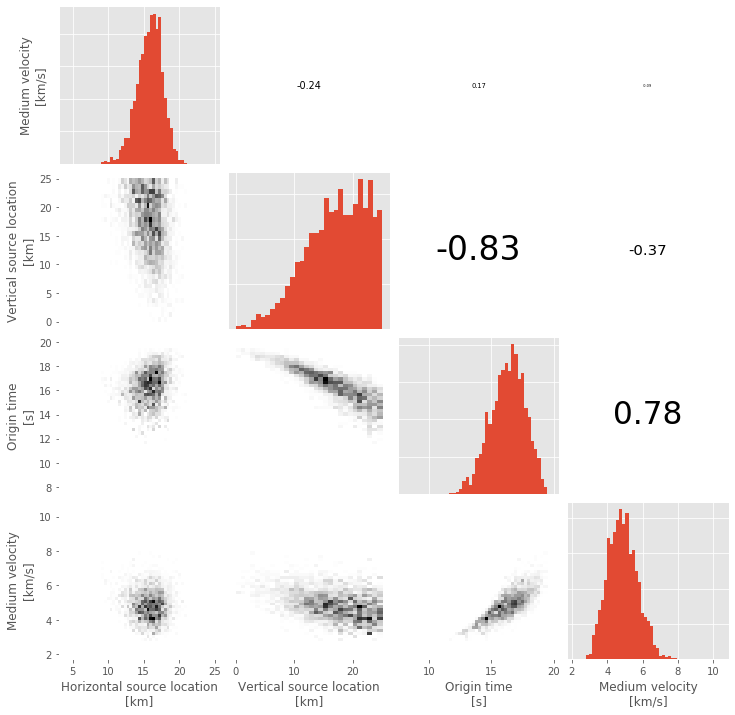

In [18]:
# Plot the Hamiltonian Monte Carlo 2D marginals
marginal_grid(
    samples_HMC,
    [0, 1, 2, 3],
    bins=30,
    labels=[f"{l}\n[{u}]" for l, u in zip(target.labels, target.units)],
    color_1d=None,
    limits=limits
)

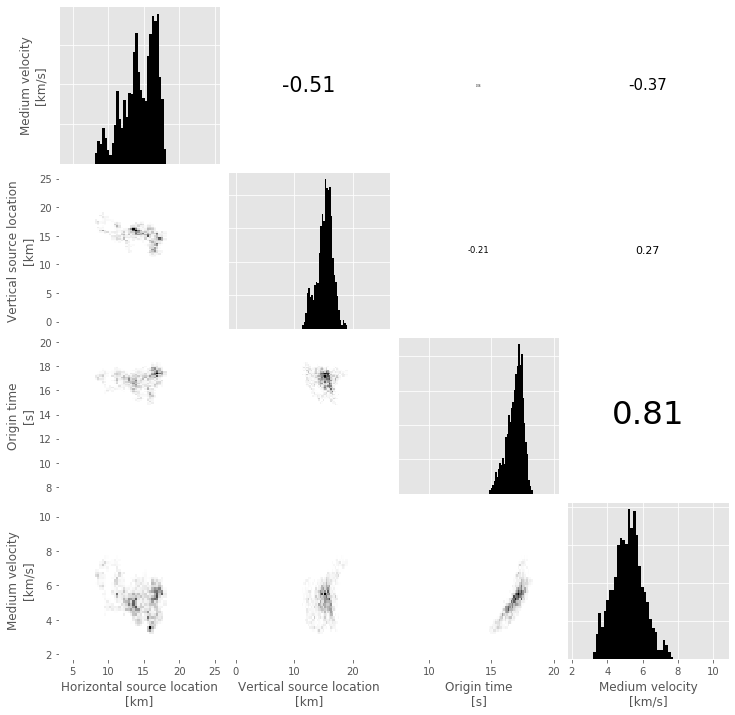

In [19]:
# Plot the Metropolis-Hastings 2D marginals

marginal_grid(
    samples_MH,
    [0, 1, 2, 3],
    bins=30,
    labels=[f"{l}\n[{u}]" for l, u in zip(target.labels, target.units)],
    limits=limits
)

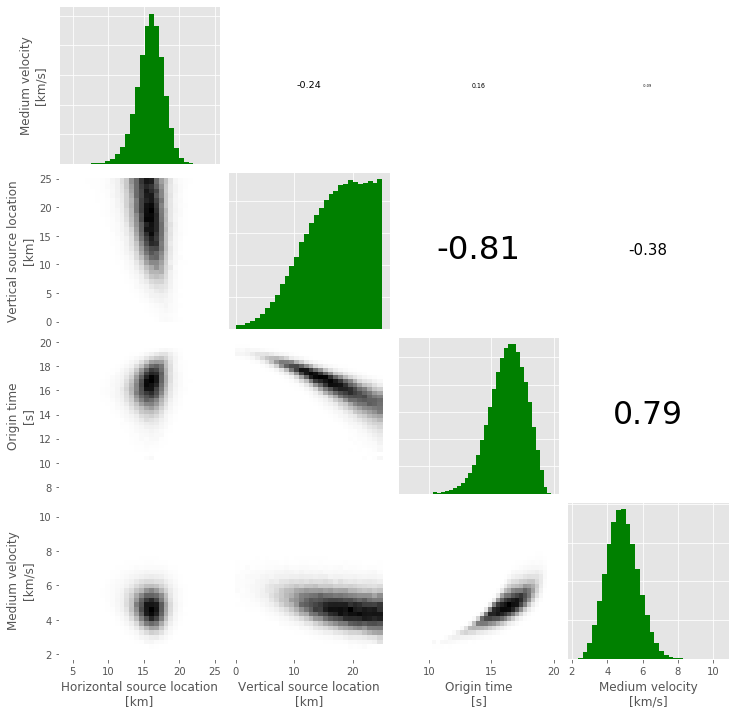

In [20]:
# Plot the reference solution 2D marginals
marginal_grid(
    samples_HMC_REF, # or samples_MH_REF
    [0, 1, 2, 3],
    bins=30,
    labels=[f"{l}\n[{u}]" for l, u in zip(target.labels, target.units)],
    color_1d="green",
    limits=limits
)

# Section 4: What does it all mean?

So, we've succesfully sampled the distributions with both MH and HMC. But let's now quickly go back to the actual inverse problem itself. This is note elementary when trying to understand the HMC algorithm, but it's maybe good for our physical intuition.

Looking at the marginals of the previous notebook cells, we can see that there are **strong trade-offs between medium velocity, origin time, and vertical source location**. These parameters are quite unconstratined together. Horizontal source location seems to be much better resolved.

When we visualize the marginal of hypocenter location (horizontal and vertical location, **in the next notebook cell**) we can see how poorly the inference constrains vertical location.

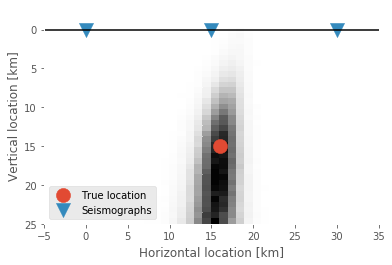

In [21]:
# Plot the distribution of possible event locations
axes = plt.axes()
axes.hist2d(
    samples_HMC_REF[0, :],
    samples_HMC_REF[1, :],
    bins=40,
    range=[[-5, 35], [-3, depth_limit]],
    cmap=plt.get_cmap("Greys"),
)
axes.invert_yaxis()
axes.set_xlabel("Horizontal location [km]")
axes.set_ylabel("Vertical location [km]")

axes.plot([-5, 35], [0, 0], "k")
axes.scatter(m_true[0], m_true[1], 200, label="True location")
axes.scatter(station_x, station_z, 200, label="Seismographs", marker="v")
axes.legend()

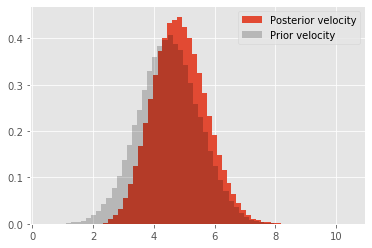

Standard deviation prior to the experiment: 1.00
Standard deviation after to the experiment: 0.88
It seems like we learned something about the velocity!


In [22]:
# Plot the knowledge on the medium velocity
prior_velocities = np.random.randn(100000) * v_std + v_mean
posterior_velocities = samples_HMC_REF[-2, :]

plt.hist(
    posterior_velocities, bins=50, density=True, label="Posterior velocity"
)
plt.hist(
    prior_velocities,
    bins=50,
    density=True,
    alpha=0.2,
    color="k",
    label="Prior velocity",
)
plt.legend()
plt.show()

print(f"Standard deviation prior to the experiment: {np.std(prior_velocities):.2f}")
print(f"Standard deviation after to the experiment: {np.std(posterior_velocities):.2f}")

if np.std(posterior_velocities) < np.std(prior_velocities):
    print("It seems like we learned something about the velocity!")

# Section 5: The mass matrix

To illustrate the influence of the mass matrix, we'll try to evaluate the exact same event, but with a much better knowledge of the medium velocity. Our prior knowledge on velocity is now centered at 4.9, with a much smaller 'spread' (standard deviation). A prior that is so informative is often called a **'strong prior'**.

In [23]:
# Create an inference problem with a strong prior.

v_mean = 4.95
v_std = 0.04

# Collect the inverse problem into a object using the class 'template'
target_with_strong_prior = target_tt(t_obs, uncertainties, station_x, station_z, v_mean, v_std, depth_limit)

Great, we have a target distribution with an updated (stronger) prior. 

We can now recreate the exact same HMC Markov chain (the same tuning settings) on this new distribution.

In [24]:
# Sample the strong prior target using the HMC algorithm
m_start = np.array([16.1, 15.2, 17.3, 4.7])[:, np.newaxis]

# Tuning parameters
# mass_matrix = np.eye(4)
mass_matrix = np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1],], dtype=np.float32
)
dt = 0.13
nt = 40
number_of_samples = 50

# Sampling
samples_HMC = samplers.sample_hmc_opt(
    target_with_strong_prior, m_start, nt, dt, number_of_samples, mass_matrix
)

Oh-oh! Something that worked before, doesn't work anymore. **Almost no accepted samples.** What could this be?

Well, obviously, this is due to the change in target distribution. What likely happened, is that this target is much more constrained than the previous target (especially in the velocity dimension, number 4). The mass matrix was not updated accordingly, so sampling kind of failed (read: no samples are being generated).

We can visualize this by animating the proposals. Again, we use a precomputed reference solution for visualization purposes, but this we wouldn't have a-priori.

Once you understand what you might want to change in the tuning parameters, go ahead and **update the tuning parameters** s.t. you get an acceptance rate of about 50%. **What effect has your change on the trajectories**?

<IPython.core.display.Javascript object>


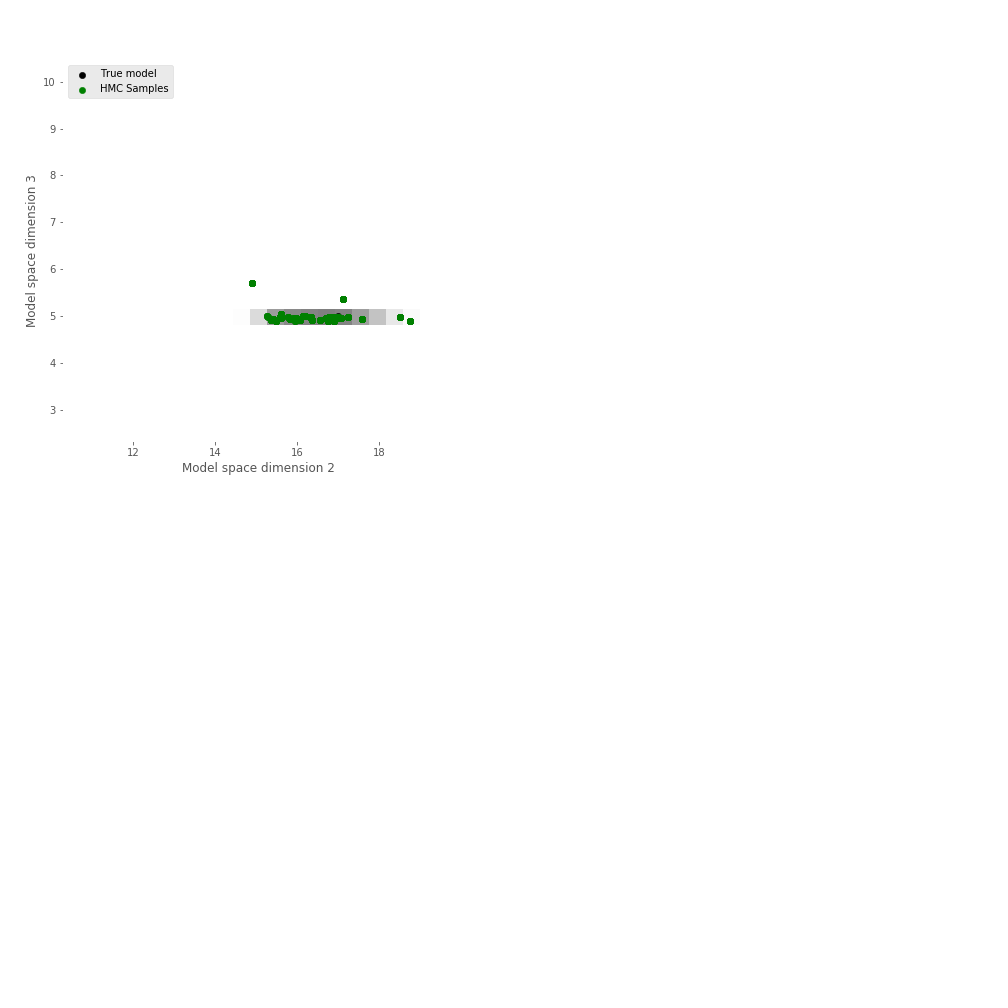

In [25]:
# Sample the strong prior problem, animated

samples_HMC_strong_prior_REF = np.load(
    "ref_solutions/single_event_reference_HMC_three_receivers_strong_prior.npy"
)

# Select a starting model
m_start = np.array([16.1, 15.2, 14.9, 5.7])[:, None]

# Choose which dimensions to animate
dim_to_vis = [2, 3]
figsize = (7, 7)
animate_trajectory = (
    True  # Disable this with 'False' if you find the animation annoying
)
animate_trajectory_interval = 10  # Lower this number to slow down the animation

# Tuning parameters =============================================================================================
mass_matrix = np.array(
    [[1, 0, 0, 0], 
     [0, 1, 0, 0], 
     [0, 0, 1, 0], 
     [0, 0, 0, 10],], 
    dtype=np.float32
)
dt = 0.13
nt = 40
number_of_samples = 50

# Sampling! =====================================================================================================
%matplotlib notebook
samples_HMC_strong_prior = samplers.visual_sample_hmc(
    target_with_strong_prior,
    m_start,
    nt,
    dt,
    number_of_samples,
    mass_matrix,
    figsize=figsize,
    dims_to_visualize=dim_to_vis,
    background_samples=samples_HMC_strong_prior_REF,
    true_m=m_true,
    animate_trajectory=animate_trajectory,
    animate_trajectory_interval=animate_trajectory_interval,  # Lower this number to slow down the animation
)
%matplotlib inline

Updating the mass matrix helps a lot when the multidimensional distribution doesn't have a unit covariance matrix. This is of course almost never the case, which is why tuning the mass matrix is very important for HMC. There are many strategies, some use prior knowledge on the physics and some are automated. These techniques are beyond the scope of this notebook.

Let's now quickly (using the reference solution take a look what effect updating the prior has on our solution. We sample the distribution with the updated mass matrix first.

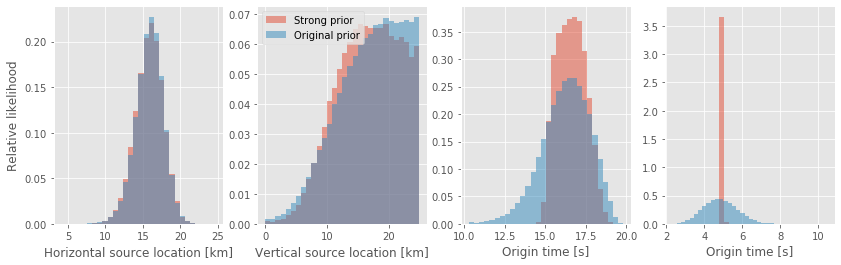

In [26]:
# Plot the result of the strong prior inference versus the original inference
figure, axess = plt.subplots(1, 4, figsize=(14, 4))

axess[0].set_ylabel("Relative likelihood")

for i in range(3):
    axess[i].hist(
        samples_HMC_strong_prior_REF[i, :],
        bins=30,
        label="Strong prior",
        alpha=0.5,
        density=True,
    )
    axess[i].hist(
        samples_HMC_REF[i, :], bins=30, label="Original prior", alpha=0.5, density=True
    )
    axess[i].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))

axess[-1].hist(
    samples_HMC_strong_prior_REF[-2, :],
    bins=30,
    label="Strong prior",
    alpha=0.5,
    density=True,
)
axess[-1].hist(
    samples_HMC_REF[-2, 1000:],
    bins=30,
    label="Original prior",
    alpha=0.5,
    density=True,
)
axess[-1].set_xlabel("%s [%s]" % (target.labels[-2], target.units[-2]))

axess[1].legend()

So the increased knowledge helped us delineat both origin time and vertical source location better. We can also see that the 2D marginals containign velocity almost 'collapse':

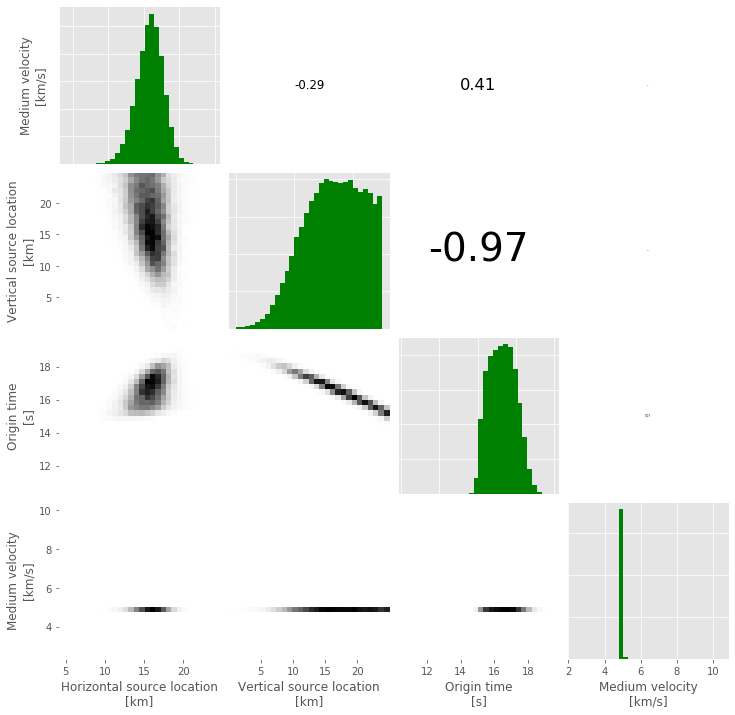

In [27]:
# Plot the reference solution 2D marginals
marginal_grid(
    samples_HMC_strong_prior_REF,
    [0, 1, 2, 3],
    bins=30,
    labels=[f"{l}\n[{u}]" for l, u in zip(target.labels, target.units)],
    color_1d="green",
)

# Conclusion: With as many samples, HMC typically gives better results compared to MH.

But we've also seen that **HMC generates samples much slower**. In Notebook 2 we see a performance comparison when HMC and MH are pitted against each other.

**End of the Notebook 1.**

 ↓ Bonus material is that way ↓

 # Changing the acquisition set-up, changing the mass matrix

We try our inversion once again, but now the data is observed by a **high-density** receiver network.

Intuitively, if we use more stations, our solution should become less uncertain. What this would imply for the posterior is that **the spread (or more mathematically the covariance) would become smaller**.

 

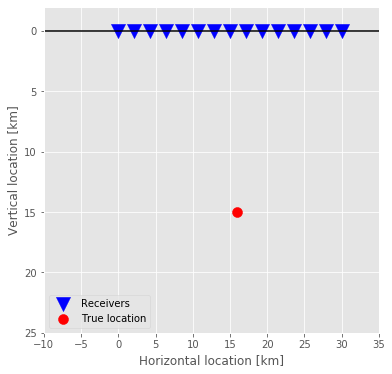

In [28]:
# Create a high-density receiver network

# Define earthquake source properties
source_x = 16.0
source_z = 15.0
origin_T = 17.0
v_exact = 5.0

# Define station coordinates of the array
station_x_dense = np.linspace(0, 30, 15)
station_z_dense = np.zeros_like(station_x_dense)

fig, axes = plt.subplots(figsize=(6,6))
axes.scatter(station_x_dense, station_z_dense, color='b', marker='v', s=200, label='Receivers')
axes.scatter(source_x, source_z, color='r', marker='.', s=400, label='True location')
axes = plt.gca()
axes.set_xlabel("Horizontal location [km]")
axes.set_ylabel("Vertical location [km]")
axes.plot([-10, 35], [0, 0], "k")
axes.set_xlim([-10,35])
axes.set_ylim([25,-2])
axes.legend();

In [29]:
# Create the inverse problem from this high-density receiver network

# Create a vector out of the true values
m_true = np.array([source_x, source_z, origin_T, v_exact])

# Calculate observed (exact) arrival times for all stations
t_obs = forward(m_true, station_x_dense, station_z_dense)

# Define uncertainties for the observed arrival time at each station. These are repeated for all events.
uncertainties = np.ones_like(station_x_dense) * 0.2
uncertainties[
    0
] = 0.5  # Just to recreate the first station from previous implementation

assert t_obs.size == uncertainties.size

# Prior information on depth and velocity
v_mean = 4.5
v_std = 1
depth_limit = 25.0
target_many_receivers = target_tt(
    t_obs, uncertainties, station_x_dense, station_z_dense, v_mean, v_std, depth_limit
)

Now, initially, sampling will not work. Try to find a mass matrix that does have a high acceptance rate for this target.

In [ ]:
# Sample this inverse problem with exactly the same settings as the first targets

# Sampling using the basic HMC algorithm
m_start = np.array([16.1, 15.2, 17.3, 4.7])[:, np.newaxis]

# Tuning parameters
# mass_matrix = np.eye(4)
mass_matrix = 10 * np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1],], dtype=np.float32
)
dt = 0.13
nt = 40
number_of_samples_dense = 5000

# Sampling
samples_HMC_many_receivers = samplers.sample_hmc_opt(
    target_many_receivers, m_start, nt, dt, number_of_samples_dense, mass_matrix
)

In [ ]:
# Plot the reference solution 2D marginals
marginal_grid(
    samples_HMC_many_receivers,
    [0, 1, 2, 3],
    bins=30,
    labels=[f"{l}\n[{u}]" for l, u in zip(target.labels, target.units)],
    color_1d="green",
    limits=limits,
)

 Evidently, the updated receiver network strongly improves the quality of locating Earthquakes, but doesn't give us much more information on the medium parameters.

# Reference solutions

### HMC reference samples

In [ ]:
# Reference solution

m_start = np.array([16.1, 15.2, 14.9, 5.7])[:, None]

epsilon = 0.15
nt = 10
number_of_samples_ref = 4000000

mass_matrix = np.eye(4)

# Uncomment to run
# samples_HMC_REF = samplers.sample_hmc_opt(
#     target, m_start, nt, epsilon, number_of_samples_ref, mass_matrix, thinning=10
# )

In [ ]:
# np.save("ref_solutions/single_event_reference_HMC_three_receivers.npy", samples_HMC_REF)

### Metropolis-Hastings reference samples

In [ ]:
# Sample using the basic MH algorithm
m_start = np.array([16.1, 15.2, 14.9, 5.7])[:, None]

epsilon = 0.15
number_of_samples = 4000000

# Uncomment to run
# samples_MH_REF = samplers.sample_mh(target, m_start, epsilon, number_of_samples, thinning=10);

In [ ]:
# np.save("ref_solutions/single_event_reference_MH_three_receivers.npy", samples_MH_REF)

### HMC reference samples for the strong prior problem

In [ ]:
# Sample using the basic HMC algorithm
m_start = np.array([16.1, 15.2, 17.3, 4.7])[:, np.newaxis]

# Tuning parameters
# mass_matrix = np.eye(4)
mass_matrix = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 10],
    ], dtype=np.float32
)  
dt = 0.13
nt = 40
number_of_samples = 360000

# Sampling
samples_HMC_strong_prior_REF = samplers.sample_hmc_opt(
    target_with_strong_prior, m_start, nt, dt, number_of_samples, mass_matrix, thinning=10
)

In [ ]:
np.save("ref_solutions/single_event_reference_HMC_three_receivers_strong_prior.npy", samples_HMC_strong_prior_REF)

Add the max and min of the original distribution, such that plotting limits are forced to be equal between the two targets.

In [ ]:
mins = np.min(samples_HMC_REF, axis=1)[:,None]
maxs = np.max(samples_HMC_REF, axis=1)[:,None]

samples_HMC_strong_prior_REF = np.hstack((samples_HMC_strong_prior_REF,maxs,mins))